# POC

## 1 Beispiel

### POC: Simple WebScraping

In [ ]:
import requests
from bs4 import BeautifulSoup

def scrape_tour_report(url):
    # Abrufen der Webseite
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extrahieren des Haupttextes
    report_div = soup.find('div', class_='main_text')
    
    if report_div:
        report_text = report_div.get_text(strip=True)
    else:
        report_text = "Kein Haupttext gefunden. Überprüfe die Struktur der Webseite."

    # Extrahieren des Titels
    title_tag = soup.find('h1', class_='title')
    
    if title_tag:
        title = title_tag.get_text(strip=True)
    else:
        title = "Kein Titel gefunden."

    return title, report_text

# Beispielaufruf
url = 'https://www.hikr.org/tour/post152638.html'  # Beispiel-URL
title, report_text = scrape_tour_report(url)
print(f"Title: {title}\nReport:\n{report_text}")


### POC: Sentiment + Keyword-SUCHE

In [ ]:
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Lade das deutsche Sprachmodell von spaCy
nlp = spacy.load('de_core_news_sm')

def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    return sentiment

def find_exposure_mentions(text):
    # Definiere die Schlüsselwörter in ihrer Grundform
    keywords = ["exponiert", "Absturzgefahr", "luftig", "ausgesetzt"]

    # Wandle den Text in ein spaCy-Dokument um
    doc = nlp(text)
    
    mentions = []
    
    for sentence in doc.sents:
        # Lemmatize jedes Wort im Satz und überprüfe, ob eines der Schlüsselwörter vorhanden ist
        if any(token.lemma_ in keywords for token in sentence):
            mentions.append(sentence.text.strip())
    
    return mentions


# Sentiment-Analyse
sentiment = analyze_sentiment(report_text)
print(f"Sentiment Analysis: {sentiment}")

# Themenerkennung „Exponiertheit“
exposure_mentions = find_exposure_mentions(report_text)
print("Mentions of Exposure:\n", exposure_mentions)


## Weiterentwicklung
Nun gilt es den erfolgreichen Code im POC auf das nächste Level zu brigen. Weiterentwicklung für komplexere Extraktionen. In diesem Abschnitt ist das Ziel, den Code soweit zu bringen, dass ich ihn für die Datenbeschaffung, sprich das Fine-Tuning nutzen kann. Vollständige Berichte extrahieren und diese dann mittels spaCy weiter zu verarbeiten. Somit erspare ich mir einerseits das stupide rauskopieren der Berichte, andererseits das Durchlesen aller Berichte selbst. Zusammengefasst bedeutet es nun:

*   **Webscraping:** Datenpipeline bauen für Bericht-Extraktion
*   **spaCy:** Keyword suche die relevanten stellen zu finden
*   **CSV-Output:** Relevante Stellen in ein CSV schreiben
*   **Daten Labeln:** Die Sätze händisch labeln für das fine-tuning

### Webscraping 2.0

In [ ]:
import requests
from bs4 import BeautifulSoup
import time

def scrape_region_pages(base_url, max_pages):
    all_reports = []
    seen_urls = set()  # Set to track seen URLs
    for page in range(1, max_pages + 1):
        # Zusammensetzen der URL für die jeweilige Seite
        page_url = f"{base_url}/tour/?skip={(page - 1) * 10}&"
        print(f"Fetching page: {page_url}")
        response = requests.get(page_url)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Alle relevanten Links zu Tourberichten auf der Seite finden
        for link in soup.find_all('a', href=True):
            if "tour/post" in link['href']:
                # URL richtig zusammensetzen
                report_url = link['href']
                if not report_url.startswith("http"):
                    report_url = f"https://www.hikr.org{report_url}"
                
                # Überprüfen, ob die URL bereits gesehen wurde
                if report_url not in seen_urls:
                    seen_urls.add(report_url)  # URL zur Menge hinzufügen
                    print(f"Fetching report: {report_url}")
                    try:
                        title, report_text = scrape_tour_report(report_url)
                        all_reports.append({'title': title, 'text': report_text})
                    except requests.exceptions.RequestException as e:
                        print(f"Error fetching {report_url}: {e}")
                    
                    # Kurze Pause zwischen den Anfragen
                    time.sleep(2)
    
    return all_reports

def scrape_tour_report(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        soup = BeautifulSoup(response.text, 'html.parser')
    
        # Extrahieren des Haupttextes
        report_div = soup.find('div', class_='main_text')

        # Extrahiere den Haupttext des Berichts
        if report_div:
            report_text = report_div.get_text(strip=True)
        else:
            report_text = "Kein Haupttext gefunden. Überprüfe die Struktur der Webseite."

        # Extrahieren des Titels
        title_tag = soup.find('h1', class_='title')
        
        if title_tag:
            title = title_tag.get_text(strip=True)
        else:
            title = "Kein Titel gefunden."

        return title, report_text
    except requests.exceptions.RequestException as e:
        print(f"Failed to retrieve {url}: {e}")
        raise  # Optional: Reraise the exception if you want it to propagate

# Beispiel: Scrape die ersten 5 Seiten einer Region
base_url = "https://www.hikr.org/region109"
all_reports = scrape_region_pages(base_url, max_pages=1)

# Ergebnisse anzeigen
for report in all_reports:
    print(f"Title: {report['title']}\nText: {report['text'][:200]}...\n")


### spaCy -> CSV

Eine Skala von 1 bis 4 zur Bewertung der Exponiertheit und Herausforderung einer Route wird zu meinem Ansatz. Diese Skala bietet eine klare Differenzierung, ohne zu detailliert zu werden, und ist einfacher anzuwenden. Sowohl psychologische (subjektive) Faktoren wie "Schwindelfreiheit erforderlich" als auch objektive Gefahren wie "Steinschlaggefahr" werden die Bewertung einfliessen.

In [ ]:
import spacy
import csv

# spaCy-Laden
nlp = spacy.load("de_core_news_sm")

# Beispiel-Schlüsselwörter
keywords = [
    "exponiert", "Absturzgefahr", "luftig", "ausgesetzt", "exponierte Stellen",
    "abgrund", "steil abfallend", "steil", "gefährdete Zone", "kritischer Punkt",
    "potenzielle Gefahr", "unpassierbar", "abgerutscht", "sturzgefährdet",
    "schwankend", "unstabil", "brüchig", "nicht gesichert", "Gletscher", "Gehgelände",
    "Blankeis", "Abstiegsgefahr", "Hangrutschung", "Lawinengefahr", "Gletscherspalte",
    "Unwetter", "Gefahr", "Schwierigkeitsgrad", "geröllbeladen", "geröll", "kraxeln", "Kraxelei",
    "schlechte Sicht", "Eispassage", "Eis", "Pickel", "Höhenangst", "Trittsicherheit",
    "anseilen", "riskant", "klettern", "Kletterpassage", "schwierig", "schmal", "Schwindel", "Schwindelfreiheit",
    "gesichert", "absturzgefährdet", "Bohrhaken", "seilfrei", "T4", "T5", "T6", "III", "Kette", "Seil",
    "einfach", "genervt", "Weg", "Klettern", "ausgerüstet", "Bohrhaken", "Abseilstelle", "eingerichtet",
    "alpin", "Vorstieg",
]

def extract_relevant_sentences(text, keywords):
    doc = nlp(text)
    relevant_sentences = []
    for sentence in doc.sents:
        if any(keyword in sentence.text for keyword in keywords):
            relevant_sentences.append(sentence.text.strip())
    return relevant_sentences

# Beispiel: Verarbeitung der Berichte
extracted_data = []

for report in all_reports:
    title = report['title']
    text = report['text']
    relevant_sentences = extract_relevant_sentences(text, keywords)
    
    for sentence in relevant_sentences:
        extracted_data.append({
            'title': title,
            'relevant_sentence': sentence,  # Einzelner Satz
            'label': None  # Platzhalter für späteres Label
        })

# Ergebnisse in eine CSV-Datei exportieren
csv_file = "extracted_data.csv"
with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=['title', 'relevant_sentence', 'label'])
    writer.writeheader()
    for data in extracted_data:
        writer.writerow(data)

print(f"Die Daten wurden erfolgreich in die Datei '{csv_file}' exportiert.")

**HERAUSFORDERUNGEN und GEDANKEN**

Einiges wurde erst aus dem iterativen Bearbeiten klar oder überhaupt aufgedeckt. Ebenso enstanden Überlegungen erst durch das Arbeiten mit den Daten. Hier möchte ich diese kurz festhalten

*   1: Erst durch die Einsicht in die Berichte wurde klar, dass es diverse Mehr-Gipfel-Touren gibt. Zum Beispiel bei den Mythen gibt es drei Gipfel und somit werden diese nicht nur einzeln, sondern gleich als Trylogien absolviert. Habe ich selber auch gemacht, aber hier nicht daran gedacht. Also gibt es somit nicht nur eine Bewertung für einen Gipfel. Es wird pro Tour selbst bewertet, und diese kann n-Gipfel beinhalten.

*   2: Im ersten Schritt habe ich die Route auf Basis von 1 - n Sätzen gelabelt. Finde dies nicht korrekt, da ich jeden Satz einzeln labeln möchte, um das Model besser zu trainieren. Dies hilft dann auch im nächsten Schritt wo es um die Berechnung geht von der Skala 1-4

*   3: Einfache Touren! Im Test habe ich 10 Routen extrahiert, 8 /10 sah ich. Problem war, dass kein Keywort gefunden wurde (nur die Such nach negativen Sätzen). Habe und werde iterativ neue Keywords einsetzen ("einfach" usw.). Dann sah ich 9/10

*   4: Sprache: Um 10 / 10 zu erhalten kontrollierte ich nochmals alle Routen und sah, eine davon war auf italienisch. Dies sind dann aber auch irrelevant

*   5: Kontext: Die Sätze zu labeln ist bereits sehr gut. Aber noch hilfreicher im Kontext der Objektiven Bewertung der Tour. In V2 ergänzt

*   6: **!!!** Mit meinem Datenextraktionsverfahren kann ich das Ziel erreichen, mein ML zu optimieren. Daten sammeln, vorbereiten und nutzen. Was aber NICHT geht mit dieser Pipeline, ist eine End-Produkt Sicht. Finales Ziel wäre, n-Berichte der Route 1 die zu Gipfel A führt zu konsolidieren und klassifizieren. Dieser Schritt ist nicht Ziel dieser Arbeit. Ziel ist ein ML zu entwicklen das für diese sog. finale Applikation / Produkt eingesetzt werden kann. **!!!**

# Daten und ML Test

## Data Engineering
Augbau einer Datapipeline für folgenden Prozess welchen ich aus dem ersten CAS BigData gelernt habe. Daran möchte ich mich orientieren. Mit untenstehendem Code erreiche ich über das Scraping quasi die Ingestion, Tranformation. Im nächsten Schritt wird das Serving erbracht in dem eine CSV Datei generiert wird. Storage findet somit immer auf meinem MacBook statt.

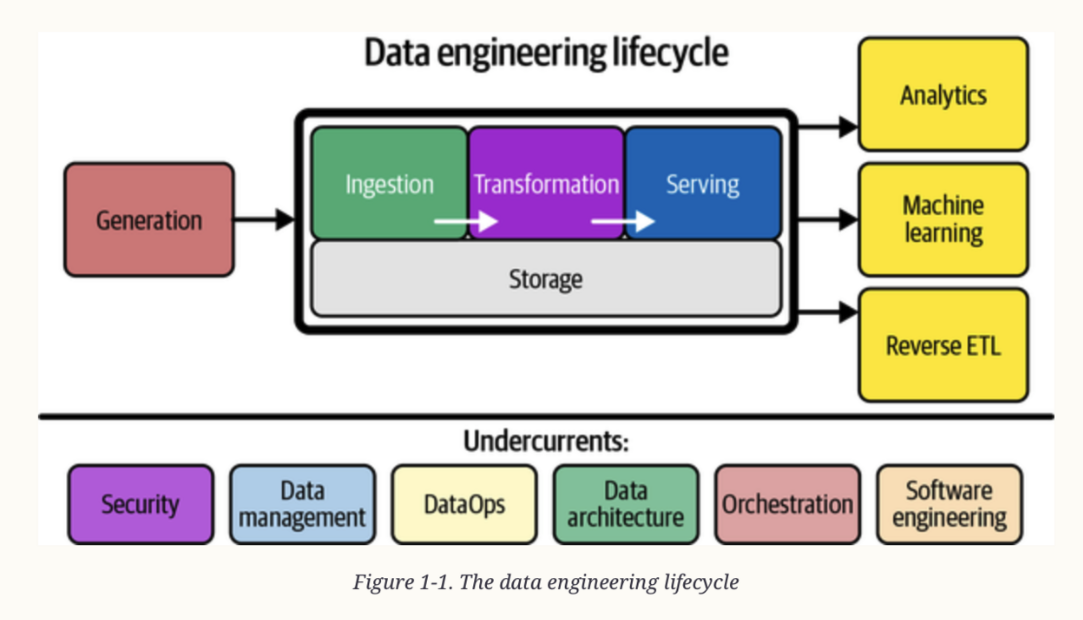

### Ingestion

In [4]:
import requests
from bs4 import BeautifulSoup
import time

# Funktionen noch besser kommentieren
def scrape_region_pages(base_url, max_pages):
    all_reports = []
    seen_urls = set()
    
    for page in range(1, max_pages + 1):
        page_url = f"{base_url}/tour/?skip={(page - 1) * 10}&"
        print(f"Fetching page: {page_url}")
        response = requests.get(page_url)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Zwischenspeicher für die aktuelle Schwierigkeitsstufe
        current_difficulties = []
        
        for content in soup.find_all(['span', 'strong']):
            if content.name == 'span' and 'title' in content.attrs:
                title_attr = content['title']
                if 'Schwierigkeit' in title_attr:
                    difficulty = content.get_text(strip=True)
                    current_difficulties.append(difficulty)
                    
            elif content.name == 'strong' and content.find('a'):
                link = content.find('a')
                report_url = link['href']
                if not report_url.startswith("http"):
                    report_url = f"https://www.hikr.org{report_url}"
                
                if report_url not in seen_urls:
                    seen_urls.add(report_url)
                    print(f"Fetching report: {report_url}")
                    try:
                        title, report_text = scrape_tour_report(report_url)
                        difficulty_str = " | ".join(current_difficulties) if current_difficulties else "Keine Schwierigkeitsangabe"
                        all_reports.append({'title': title, 'text': report_text, 'difficulty': difficulty_str})
                    except requests.exceptions.RequestException as e:
                        print(f"Error fetching {report_url}: {e}")
                    
                    # Nach Verarbeitung einer Tour die aktuelle Schwierigkeit leeren
                    current_difficulties = []
                    
                    time.sleep(1)
    
    return all_reports

def scrape_tour_report(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
    
        report_div = soup.find('div', class_='main_text')
        report_text = report_div.get_text(strip=True) if report_div else "Kein Haupttext gefunden. Überprüfe die Struktur der Webseite."

        title_tag = soup.find('h1', class_='title')
        title = title_tag.get_text(strip=True) if title_tag else "Kein Titel gefunden."
        
        return title, report_text
    except requests.exceptions.RequestException as e:
        print(f"Failed to retrieve {url}: {e}")
        raise

In [5]:
# Scrape die ersten X-Seiten einer Region / Kanton, aus der Schwei
base_url_sz = "https://www.hikr.org/region109"
base_url_gr = "https://www.hikr.org/region4"
base_url_ur = "https://www.hikr.org/region146"
base_url_vs = "https://www.hikr.org/region3"

# Versuch über alle neuen Einträge in der Schweiz (region2)
# Sehr kuul, lediglich die Region in der URL Änderung und die Struktur bleibt gleich, ergo gleicher Code läuft
base_url_ch = "https://www.hikr.org/region2"

all_reports = scrape_region_pages(base_url_vs, max_pages=20)

# Ergebnisse anzeigen
for report in all_reports:
    print(f"Title: {report['title']}\nText: {report['text'][:200]}...\nDifficulty: {report['difficulty']}")

Fetching page: https://www.hikr.org/region3/tour/?skip=0&
Fetching report: https://www.hikr.org/tour/post190288.html
Fetching report: https://www.hikr.org/tour/post190290.html
Fetching report: https://www.hikr.org/tour/post190229.html
Fetching report: https://www.hikr.org/tour/post190166.html
Fetching report: https://www.hikr.org/tour/post189975.html
Fetching report: https://www.hikr.org/tour/post189926.html
Fetching report: https://www.hikr.org/tour/post189991.html
Fetching report: https://www.hikr.org/tour/post189894.html
Fetching report: https://www.hikr.org/tour/post189898.html
Fetching report: https://www.hikr.org/tour/post189924.html
Fetching page: https://www.hikr.org/region3/tour/?skip=10&
Fetching report: https://www.hikr.org/tour/post189849.html
Fetching report: https://www.hikr.org/tour/post189828.html
Fetching report: https://www.hikr.org/tour/post189802.html
Fetching report: https://www.hikr.org/tour/post189799.html
Fetching report: https://www.hikr.org/tour/post189980.htm

### Transformation

In [ ]:
# Keywordsuche für alle möglichen Sätze aus den Berichten
keywords = [
    "exponiert", "Absturzgefahr", "luftig", "ausgesetzt", "exponierte Stellen",
    "abgrund", "steil abfallend", "steil", "gefährdete Zone", "kritischer Punkt",
    "potenzielle Gefahr", "unpassierbar", "abgerutscht", "sturzgefährdet",
    "schwankend", "unstabil", "brüchig", "nicht gesichert", "Gletscher",
    "Blankeis", "Abstiegsgefahr", "Hangrutschung", "Lawinengefahr", "Gletscherspalte",
    "Unwetter", "Gefahr", "Schwierigkeitsgrad", "geröllbeladen", "geröll", "kraxeln", "Kraxelei",
    "schlechte Sicht", "Eispassage", "Eis", "Pickel", "Höhenangst", "Trittsicherheit",
    "anseilen", "riskant", "klettern", "Kletterpassage", "schwierig", "schmal", "Schwindel", "Schwindelfreiheit",
    "gesichert", "absturzgefährdet", "seilfrei", "T4", "T5", "T6", "III", "Kette", "Seil",
    "einfach", "genervt", "Weg", "Klettern", "ausgerüstet", "Bohrhaken", "Abseilstelle", "eingerichtet",
]

In [6]:
# Angepasste Keywordsuche für mehr negative Beispiele
# Diese kommen am wenigsten hervor
keywords = [
    "exponiert", "Absturzgefahr", "luftig", "ausgesetzt", "exponierte Stellen",
    "sturzgefährdet", "kraxeln", "Kraxelei", "Trittsicherheit", "klettern", "Kletterpassage",
    "schwierig", "schmal", "Schwindel", "Schwindelfreiheit", "gesichert", "absturzgefährdet",
    "Bohrhaken", "Kette", "Seil", "ausgerüstet", "Abseilstelle", "eingerichtet",
]

In [7]:
import spacy
import csv

# spaCy-Laden
nlp = spacy.load("de_core_news_sm")

def extract_relevant_sentences(text, keywords):
    doc = nlp(text)
    relevant_sentences = []
    for sentence in doc.sents:
        if any(keyword in sentence.text for keyword in keywords):
            relevant_sentences.append(sentence.text.strip())
    return relevant_sentences

# Beispiel: Verarbeitung der Berichte
extracted_data = []

for report in all_reports:
    title = report['title']
    text = report['text']
    difficulty = report['difficulty']  # Die Schwierigkeit aus dem Bericht extrahieren
    relevant_sentences = extract_relevant_sentences(text, keywords)
    
    for sentence in relevant_sentences:
        sentence_with_difficulty = f"{sentence} | {difficulty}"  # Schwierigkeit am Ende des Satzes hinzufügen
        extracted_data.append({
            'title': title,
            'relevant_sentence': sentence_with_difficulty,  # Einzelner Satz mit Schwierigkeit
            'label': None  # Platzhalter für späteres Label
        })



### Serving

In [8]:
# Ergebnisse in eine CSV-Datei exportieren
csv_file = "extracted_data_vs.csv"
with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=['title', 'relevant_sentence', 'label'])
    writer.writeheader()
    for data in extracted_data:
        writer.writerow(data)

print(f"Die Daten wurden erfolgreich in die Datei '{csv_file}' exportiert.")

Die Daten wurden erfolgreich in die Datei 'extracted_data_vs.csv' exportiert.


#### Trainingsdaten Handling

pd.read_csv() liest die Header korrekt ein: Wenn Sie pd.read_csv('datei.csv') verwenden, liest pandas standardmäßig die erste Zeile der CSV-Datei als Header und verwendet diese, um die Spaltennamen des DataFrames festzulegen. Die folgenden Zeilen werden als Daten interpretiert.
Beim Verwenden von pd.concat() werden nur die Daten zusammengeführt: Da die Spaltennamen (Header) bereits in den einzelnen DataFrames (df1 und df2) festgelegt sind, führt pd.concat() nur die Datenzeilen zusammen. Die Spaltennamen dienen als Referenz, um sicherzustellen, dass die Daten korrekt ausgerichtet sind.

In [7]:
import pandas as pd

df_1 = pd.read_csv('training_data_v2.csv')
df_2 = pd.read_csv('training_data.csv')

df_1['label'].value_counts(), df_2['label'].value_counts()

(label
 neutral    54
 positiv    40
 negativ    36
 Name: count, dtype: int64,
 label
 neutral    289
 positiv    289
 negativ    289
 Name: count, dtype: int64)

In [8]:
merged_df = pd.concat([df_1, df_2], ignore_index=True)
merged_df['label'].value_counts()

label
neutral    343
positiv    329
negativ    325
Name: count, dtype: int64

In [9]:
# Wir führen das Downsampling durch

# Zuerst trennen wir die Daten nach Labels
df_neutral = merged_df[merged_df['label'] == 'neutral']
df_positiv = merged_df[merged_df['label'] == 'positiv']
df_negativ = merged_df[merged_df['label'] == 'negativ']

# Wir führen Downsampling für die neutralen und positiven Labels durch
df_neutral_downsampled = df_neutral.sample(n=325, random_state=42)  # random_state für Reproduzierbarkeit
df_positiv_downsampled = df_positiv.sample(n=325, random_state=42)

# Nun kombinieren wir die downgesampleten DataFrames zurück zu einem DataFrame
balanced_df = pd.concat([df_neutral_downsampled, df_positiv_downsampled, df_negativ])

# Überprüfen der neuen Verteilung
balanced_df['label'].value_counts()


label
neutral    325
positiv    325
negativ    325
Name: count, dtype: int64

In [ ]:
balanced_df.to_csv('training_data_final.csv', index=False)

## Machine Learning

### 1. Daten vorbereiten & Setup

*   **pip install** transformers datasets torch
*   **gelabelt** wurden die **Daten** von mir nun händisch. Etwas mehr als **200 Sätze.** In 50er Sets möchte ich die Performance dann testen

### 2. Daten einlesen
Vergleich anstellen: Modell ohne fine-tuning, dann mit 50 Daten dann mit 100 usw.. bis 200

In [1]:
import pandas as pd

# Lade den Datensatz
data = pd.read_csv('extracted_data_label.csv')

# Teilung in 50, 100, 200 Beispiele um die Entwicklung der Performance zu verstehen
train_50 = data[:50]
train_100 = data[:100]
train_200 = data[:200]

### 3. Modell & Tokenizer laden

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Modell und den Tokenizer
tokenizer = AutoTokenizer.from_pretrained('ssary/XLM-RoBERTa-German-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('ssary/XLM-RoBERTa-German-sentiment')

# Funktion zum Vorhersagen von Labels
def predict_label(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=-1).item()
    
    label_map = {0: 'negativ', 1: 'neutral', 2: 'positiv'}
    return label_map[predicted_label]


/Users/tobiasmaissen/Desktop/PythonProjects/CAS_ML_Semesterarbeit/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/tobiasmaissen/Desktop/PythonProjects/CAS_ML_Semesterarbeit/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


#### Perf. ohne FineTuning: 45%

In [3]:
# Vorhersagen auf dem gesamten Datensatz ohnen Finetuning
data['predicted_label'] = data['relevant_sentence'].apply(predict_label)

In [4]:
# Vergleiche die Vorhersagen mit den tatsächlichen Labels
data[['relevant_sentence', 'label', 'predicted_label']]

,relevant_sentence,label,predicted_label
0,Mit dem Mountainbike bis zur oberen Bundalp (1...,positiv,neutral
1,Nachher weiter dem blauweiss markierten Weg Ri...,neutral,neutral
2,"Schwindelfreiheit ist nötig, da diverse ausges...",negativ,neutral
3,"Diese habe ich aufsteigend gequert, was einige...",neutral,neutral
4,Was ich erst dort sah: Das Schneetälli wäre v...,positiv,neutral
...,...,...,...
213,Links von einem Felspfeiler mit Riss muss sehr...,negativ,neutral
214,Danach führen Wegspuren weiter schräg in der W...,neutral,neutral
215,"Einmal auf dem Grat, geht es unschwierig zum G...",positiv,neutral
216,Für den Abstieg brauchten wir länger als für d...,negativ,neutral


In [5]:
from sklearn.metrics import accuracy_score

# Konvertiere deine Labels zu den numerischen Werten
label_map = {'negativ': 0, 'neutral': 1, 'positiv': 2}
data['true_label'] = data['label'].map(label_map)
data['predicted_label_num'] = data['predicted_label'].map(label_map)

# Berechne die Genauigkeit
accuracy = accuracy_score(data['true_label'], data['predicted_label_num'])
print(f'Genauigkeit ohne Fine-Tuning: {accuracy * 100:.2f}%')


Genauigkeit ohne Fine-Tuning: 45.87%
